# Plot the feedbacks in single model abrupt Solar change experiments by using the radiative kernel 

## Reference: 50 year running mean

## GFDL model version

Original code written by Chenggong Wang 
> Available on [Github](https://github.com/ChenggongWang/Radiative_Response_with_Radiative_Kernel)

Modified by Maya V. Chung Jan 7 2025

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import subprocess 
import time
from scipy import stats
sstart_time0 = time.time()
import netCDF4

In [17]:
exp = '-6%solar'

FLOR_files = f'./rk_decomp/rk.decomp.FLOR.{exp}.50yrref.*.nc'
FLOR_rk = xr.open_mfdataset(FLOR_files, combine="by_coords", parallel=True)

CM21_files = f'./rk_decomp/rk.decomp.CM2.1p1.{exp}.50yrref.*.nc'
CM21_rk = xr.open_mfdataset(CM21_files, combine="by_coords", parallel=True)


# Plot Results (decomposed radiative response) in time series

In [18]:
# rh decomposition
def rh_decomposition(ds_rk):
    dR_temp_gm = (ds_rk['dR_Ta_rh_lw_gm'] + ds_rk['dR_Ta_rh_sw_gm'] + ds_rk['dR_ts_gm']).groupby('time.year').mean('time')
    dR_lr_gm   = (ds_rk['dR_LR_rh_lw_gm'] + ds_rk['dR_LR_rh_sw_gm']  ).groupby('time.year').mean('time')
    dR_clou_gm = (ds_rk['dR_cloud_lw_gm']  + ds_rk['dR_cloud_sw_gm'] ).groupby('time.year').mean('time')
    dR_wv_gm   = (ds_rk['dR_rh_lw_gm']     + ds_rk['dR_rh_sw_gm']    ).groupby('time.year').mean('time')
    dR_albe_gm = ds_rk['dR_alb_gm'].groupby('time.year').mean('time')
    dts_gm     = ds_rk['dts_gm']   .groupby('time.year').mean('time')
    
    return dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm

def conventional_decomposition(ds_rk):
    dR_temp_gm = (ds_rk['dR_ta_gm']        + ds_rk['dR_ts_gm']       ).groupby('time.year').mean('time')
    dR_lr_gm   = ds_rk['dR_lr_gm'].groupby('time.year').mean('time')
    dR_clou_gm = (ds_rk['dR_cloud_lw_gm']  + ds_rk['dR_cloud_sw_gm'] ).groupby('time.year').mean('time')
    dR_wv_gm   = (ds_rk['dR_wv_lw_gm']     + ds_rk['dR_wv_sw_gm']    ).groupby('time.year').mean('time')
    dR_albe_gm = ds_rk['dR_alb_gm'].groupby('time.year').mean('time')
    dts_gm     = ds_rk['dts_gm']   .groupby('time.year').mean('time')
    
    return dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm

def plot_decomposition(ds_rk, ax1, decomp_type='rh'):
    if decomp_type == 'rh':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = rh_decomposition(ds_rk)
    elif decomp_type == 'conventional':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = conventional_decomposition(ds_rk)
    
    ax1.plot(dts_gm,dR_temp_gm/5,'.',label='dR_Temp/5')
    ax1.plot(dts_gm,dR_clou_gm,'.',label='dR_Cloud')
    ax1.plot(dts_gm,dR_albe_gm,'.',label='dR_Albe')
    if decomp_type == 'rh':
        ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_RH')
    elif decomp_type == 'conventional':
        ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_WV')
    ax1.set_xlabel('dTs')
    ax1.axhline(0,color='k',linewidth=1,zorder=0)
    ax1.grid(linestyle='--')

# Plot functions

In [19]:
# plot full timeseries
def plot_feedbacks_ts(FLOR_rk, CM21_rk, exp):

    # RH decomposition
    fig, ax = plt.subplots(1,2,figsize=(10,5),dpi=150, constrained_layout=True,sharex=True,sharey=True)
    
    plot_decomposition(FLOR_rk,ax[0],decomp_type='rh')
    ax[0].set_title(f'FLOR')
    ax[0].legend()
    
    plot_decomposition(CM21_rk,ax[1],decomp_type='rh')
    ax[1].set_title(f'CM2.1')
    ax[1].legend()
    
    fig.suptitle(f'Feedbacks (RH decomposition): {exp}% Solar')
    
    
    # conventional decomposition
    fig, ax = plt.subplots(1,2,figsize=(10,5),dpi=150, constrained_layout=True,sharex=True,sharey=True)
    
    plot_decomposition(FLOR_rk,ax[0],decomp_type='conventional')
    ax[0].set_title(f'FLOR')
    ax[0].legend()
    
    plot_decomposition(CM21_rk,ax[1],decomp_type='conventional')
    ax[1].set_title(f'CM2.1')
    ax[1].legend()
    
    fig.suptitle(f'Feedbacks (conventional decomposition): {exp}% Solar')

In [20]:
# calculate climate feedbacks
def calc_feedbacks(dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm, 
                   decomp_type='rh', print_output=False):
    
    # regress the RR on to ts and the slope is the climate feedback
    if decomp_type == 'conventional':
        fb_name = ['Plank','LR','Cloud','WV','Albedo']
        dR_list = {
        'Plank':dR_temp_gm-dR_lr_gm,
        'LR':dR_lr_gm,
        'Cloud': dR_clou_gm,
        'WV':dR_wv_gm,
        'Albedo':dR_albe_gm
        }
    if decomp_type == 'rh':
        fb_name = ['Plank','LR','Cloud','RH','Albedo']
        dR_list = {
        'Plank':dR_temp_gm-dR_lr_gm,
        'LR':dR_lr_gm,
        'Cloud': dR_clou_gm,
        'RH':dR_wv_gm,
        'Albedo':dR_albe_gm
        }
    if 'albedo' in decomp_type:
        fb_name = ['Albedo','Non-Albedo']
        dR_list = {
        'Albedo':dR_albe_gm,
        'Non-Albedo':dR_temp_gm+dR_clou_gm+dR_wv_gm #-dR_lr_gm+dR_lr_gm
        }
    
    slope_list = []
    for name in fb_name:

        fb = stats.linregress(dts_gm, dR_list[name]).slope
        if print_output == True:
            print(f'{name:6s}:{fb:5.2f} W/m2/K')
        
        my_dict = {f'{name:6s}': fb}
        slope_list.append(my_dict)
        
    return slope_list
        
def decomp_calc_feedbacks(ds_rk, decomp_type='rh',print_output=False):
    if decomp_type not in ['conventional','rh','albedo']:
        print('Error: please input valid decomposition type: conventional, rh, albedo')
    
    if decomp_type == 'conventional':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = conventional_decomposition(ds_rk)
    
    elif decomp_type == 'rh':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = rh_decomposition(ds_rk)
    
    elif 'albedo' in decomp_type: # use the conventional decomposition
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = rh_decomposition(ds_rk)
    
    slope_list = calc_feedbacks(dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm,
                               decomp_type, print_output)
    
    return slope_list

In [21]:
import matplotlib.colors as mcolors

def plot_multiple_datasets(ax,data_list, cmap='Blues', dataset_names=['FLOR','CM2.1'], 
                           title='', legendtitle=''):
    """
    Plots multiple datasets as bar plots side by side, with bars colored based on words,
    different shadings for each dataset, and a black outline around each bar.

    Parameters:
    - data_list: List of datasets (each dataset is a list of dictionaries).
    - dataset_names: A list of names for each dataset to use in the legend.
    """
    
    if len(data_list) != len(dataset_names):
        raise ValueError("Length of data_list and dataset_names must be the same")

    num_datasets = len(data_list)
    bar_width = 0.1  # Width of each bar
    indices = np.arange(len(data_list[0]))  # Positions for the bars

    # Generate different shadings for each dataset
    colormap = plt.get_cmap(cmap)
    shadings = [colormap(i / num_datasets) for i in range(num_datasets)]

    # Iterate through datasets and plot each
    for i, data in enumerate(data_list):
        # Extract names and values for each dataset
        names = [list(item.keys())[0].strip() for item in data]  # Get the names
        values = [list(item.values())[0] for item in data]  # Get the values
        
        # Plot each dataset with an offset for the bars
        ax.bar(indices + i * bar_width, values, bar_width, label=dataset_names[i], color=shadings[i], edgecolor='black')

    # Customize the plot
    ax.set_xlabel('Feedback')
    ax.set_ylabel('W/m2/K')
    ax.set_title(title)
    ax.set_xticks(indices + bar_width * (num_datasets - 1) / 2)
    ax.set_xticklabels(names)
    ax.legend(title=legendtitle)
    ax.axhline(0,color='k',linewidth=1)
    ax.grid(linestyle='--')


In [22]:
# make empty datasets to normalize the colors between the subplots

empty_data_conventional = [{'Plank ': 0},
 {'LR    ': 0},
 {'Cloud ': 0},
 {'WV    ': 0},
 {'Albedo   ': 0}]

empty_data_rh = [{'Plank ': 0},
 {'LR    ': 0},
 {'Cloud ': 0},
 {'RH    ': 0},
 {'Albedo   ': 0}]

empty_data_albedo = [{'Albedo ': 0},
 {'Non-Albedo    ': 0}]

In [26]:
# do for different times

def barplot_feedbacks_overtime_m6(FLOR_rk, CM21_rk, decomp_type = 'rh', exp='-6'):

    if decomp_type == 'albedo': # adjust figure size
        figsize = (8,8)
    else:
        figsize = (12,5)
    
    fig, ax = plt.subplots(1,2,figsize=figsize, dpi=120, sharex=True, sharey=True)
    
    dataset_names = ['21-100','101-300','301-400','401-497','','']
    
    # compute the feedbacks (full timeseries; less reliable for linear regression)
    #f1 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(0,20*12)), decomp_type=decomp_type)
    f2 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(21*12,100*12)), decomp_type=decomp_type)
    f3 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(101*12,300*12)), decomp_type=decomp_type)
    f4 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(301*12,400*12)), decomp_type=decomp_type)
    f5 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(401*12,497*12)), decomp_type=decomp_type)
    f6 = empty_data_conventional
    f7 = empty_data_conventional
    
    # Call the function with three datasets
    plot_multiple_datasets(ax[0],[f2, f3, f4, f5, f6, f7], 
                           cmap = 'Blues_r',
                           dataset_names=dataset_names,
                          title='FLOR',
                          legendtitle='Years')
    
    #dataset_names = ['0-20','21-100','101-300','301-400','401-500','501-750','901-933']
    dataset_names = ['21-100','101-300','301-400','401-500','501-750','751-900','901-1193']
    
    # compute the feedbacks (full timeseries; less reliable for linear regression)
    #f1 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(0,20*12)), decomp_type=decomp_type)
    f2 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(21*12,100*12)), decomp_type=decomp_type)
    f3 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(101*12,300*12)), decomp_type=decomp_type)
    f4 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(301*12,400*12)), decomp_type=decomp_type)
    f5 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(401*12,500*12)), decomp_type=decomp_type)
    f6 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(501*12,750*12)), decomp_type=decomp_type)
    f7 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(751*12,900*12)), decomp_type=decomp_type)
    f8 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(900*12,1193*12)), decomp_type=decomp_type)
    
    # Call the function with three datasets
    plot_multiple_datasets(ax[1],[f2, f3, f4, f5, f6, f7, f8], 
                           cmap = 'Blues_r',
                           dataset_names=dataset_names,
                          title='CM2.1',
                          legendtitle='Years')
    
    fig.suptitle(f'Feedbacks for {exp}% Solar over time \n({decomp_type} decomp.)')
    ax[1].set_ylabel('')
    ax[1].legend(title='Years',loc='lower right')

# Plot

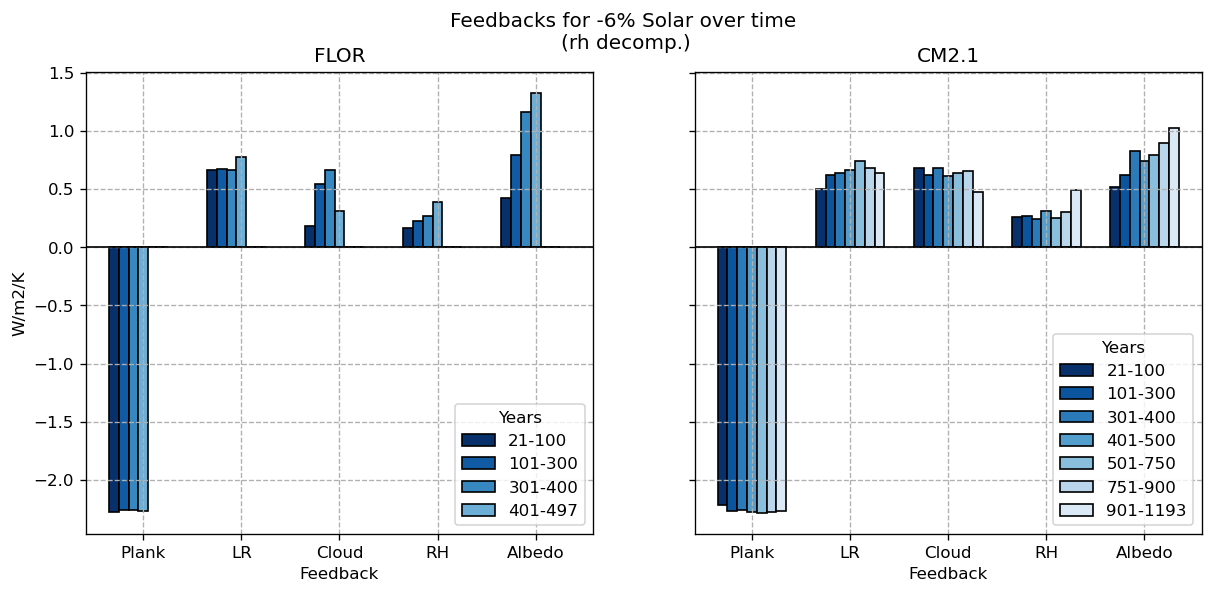

In [27]:
barplot_feedbacks_overtime_m6(FLOR_rk, CM21_rk, decomp_type = 'rh', exp='-6')

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (5,).

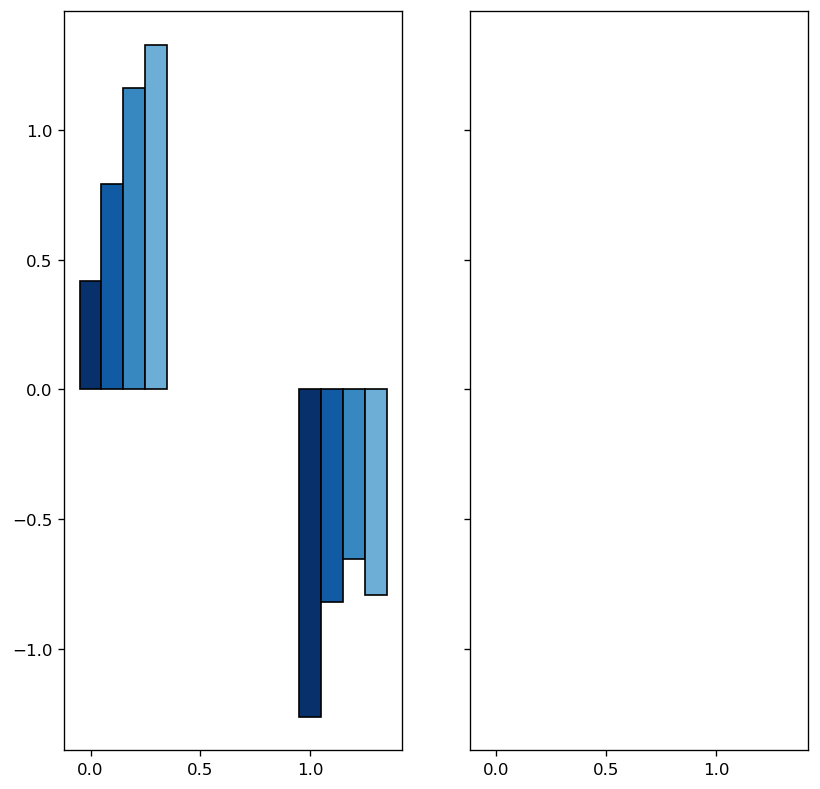

In [25]:
barplot_feedbacks_overtime_m6(FLOR_rk, CM21_rk, decomp_type = 'albedo', exp='-6')

In [8]:
# # do for different times

# decomp_type =  'conventional' # 'rh'

# fig, ax = plt.subplots(1,2,figsize=(12,5), dpi=120, sharex=True, sharey=True)

# dataset_names = ['21-100','101-300','301-400','401-497','','']

# # compute the feedbacks (full timeseries; less reliable for linear regression)
# #f1 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(0,20*12)), decomp_type=decomp_type)
# f2 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(21*12,100*12)), decomp_type=decomp_type)
# f3 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(101*12,300*12)), decomp_type=decomp_type)
# f4 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(301*12,400*12)), decomp_type=decomp_type)
# f5 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(401*12,497*12)), decomp_type=decomp_type)
# f6 = empty_data_conventional
# f7 = empty_data_conventional

# # Call the function with three datasets
# plot_multiple_datasets(ax[0],[f2, f3, f4, f5, f6, f7], 
#                        cmap = 'Blues_r',
#                        dataset_names=dataset_names,
#                       title='FLOR',
#                       legendtitle='Years')

# #dataset_names = ['0-20','21-100','101-300','301-400','401-500','501-750','901-933']
# dataset_names = ['21-100','101-300','301-400','401-500','501-750','751-900','901-933']

# # compute the feedbacks (full timeseries; less reliable for linear regression)
# #f1 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(0,20*12)), decomp_type=decomp_type)
# f2 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(21*12,100*12)), decomp_type=decomp_type)
# f3 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(101*12,300*12)), decomp_type=decomp_type)
# f4 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(301*12,400*12)), decomp_type=decomp_type)
# f5 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(401*12,500*12)), decomp_type=decomp_type)
# f6 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(501*12,750*12)), decomp_type=decomp_type)
# f7 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(751*12,900*12)), decomp_type=decomp_type)
# f8 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(900*12,933*12)), decomp_type=decomp_type)

# # Call the function with three datasets
# plot_multiple_datasets(ax[1],[f2, f3, f4, f5, f6, f7, f8], 
#                        cmap = 'Blues_r',
#                        dataset_names=dataset_names,
#                       title='CM2.1',
#                       legendtitle='Years')

# fig.suptitle(f'Feedbacks for -6% Solar over time \n({decomp_type} decomp.)')
# ax[1].set_ylabel('')
# ax[1].legend(title='Years',loc='lower right')

# Calculate feedbacks: albedo and non-albedo

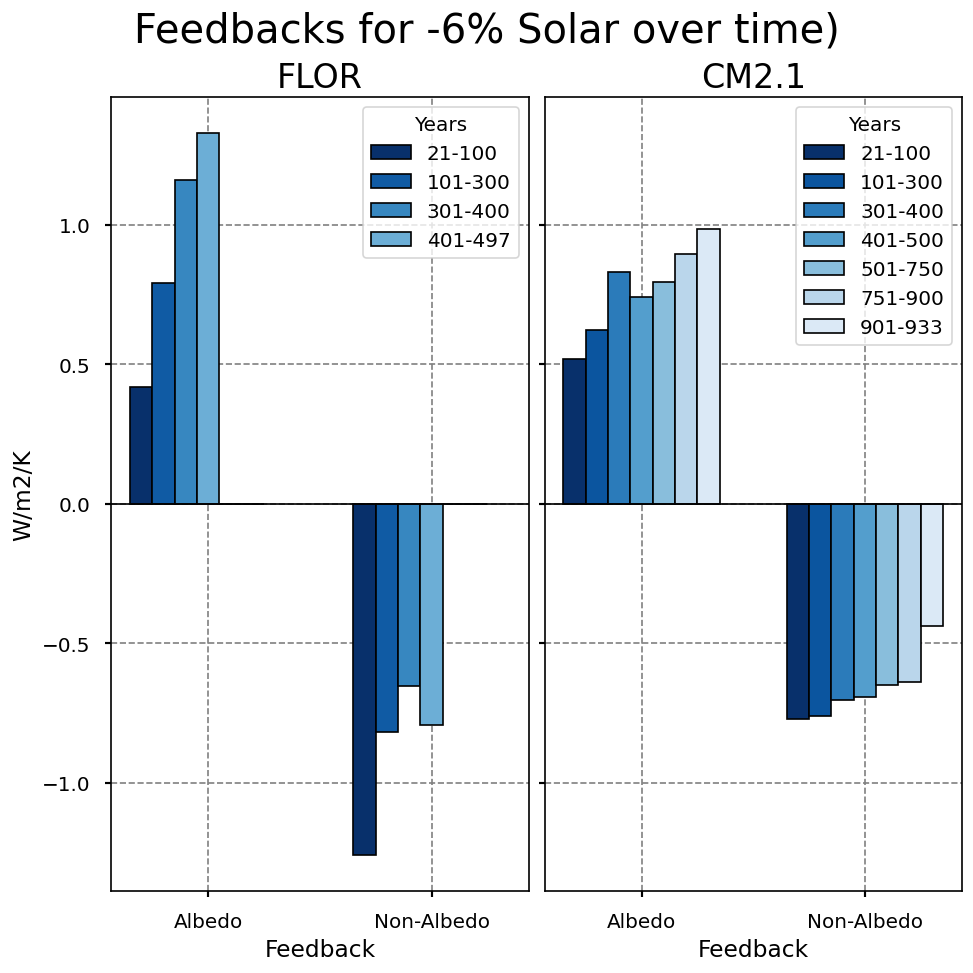

In [14]:
# # do for different times

# decomp_type =  'albedo' # 'rh'

# fig, ax = plt.subplots(1,2,figsize=(8,8), dpi=120, sharex=True, sharey=True)

# dataset_names = ['21-100','101-300','301-400','401-497','','']

# # compute the feedbacks (full timeseries; less reliable for linear regression)
# #f1 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(0,20*12)), decomp_type=decomp_type)
# f2 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(21*12,100*12)), decomp_type=decomp_type)
# f3 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(101*12,300*12)), decomp_type=decomp_type)
# f4 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(301*12,400*12)), decomp_type=decomp_type)
# f5 = decomp_calc_feedbacks(FLOR_rk.isel(time=slice(401*12,497*12)), decomp_type=decomp_type)
# f6 = empty_data_albedo
# f7 = empty_data_albedo

# # Call the function with three datasets
# plot_multiple_datasets(ax[0],[f2, f3, f4, f5, f6, f7], 
#                        cmap = 'Blues_r',
#                        dataset_names=dataset_names,
#                       title='FLOR',
#                       legendtitle='Years')

# #dataset_names = ['0-20','21-100','101-300','301-400','401-500','501-750','901-933']
# dataset_names = ['21-100','101-300','301-400','401-500','501-750','751-900','901-933']

# # compute the feedbacks (full timeseries; less reliable for linear regression)
# #f1 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(0,20*12)), decomp_type=decomp_type)
# f2 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(21*12,100*12)), decomp_type=decomp_type)
# f3 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(101*12,300*12)), decomp_type=decomp_type)
# f4 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(301*12,400*12)), decomp_type=decomp_type)
# f5 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(401*12,500*12)), decomp_type=decomp_type)
# f6 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(501*12,750*12)), decomp_type=decomp_type)
# f7 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(751*12,900*12)), decomp_type=decomp_type)
# f8 = decomp_calc_feedbacks(CM21_rk.isel(time=slice(900*12,933*12)), decomp_type=decomp_type)

# # Call the function with three datasets
# plot_multiple_datasets(ax[1],[f2, f3, f4, f5, f6, f7, f8], 
#                        cmap = 'Blues_r',
#                        dataset_names=dataset_names,
#                       title='CM2.1',
#                       legendtitle='Years')

# fig.suptitle(f'Feedbacks for -6% Solar over time)')
# ax[1].set_ylabel('')
# ax[1].legend(title='Years')

# main section (import data and plot)

In [ ]:
# plot style
plt.style.use('/tigress/mvchung/ANALYSIS/func/paper.mplstyle')

# import data

experiments = ['-4']

for exp in experiments:

    FLOR_files = f'./rk_decomp/rk.decomp.FLOR.{exp}%solar.50yrref.*.nc'
    FLOR_rk = xr.open_mfdataset(FLOR_files, combine="by_coords", parallel=True)
    
    CM21_files = f'./rk_decomp/rk.decomp.CM2.1p1.{exp}%solar.50yrref.*.nc'
    CM21_rk = xr.open_mfdataset(CM21_files, combine="by_coords", parallel=True)

    # timeseries plots
    plot_feedbacks_ts(FLOR_rk, CM21_rk, exp)

    if exp == '-6':
        barplot_feedbacks_overtime_m6(FLOR_rk, CM21_rk, decomp_type = 'rh', exp = exp)
        barplot_feedbacks_overtime_m6(FLOR_rk, CM21_rk, decomp_type = 'conventional', exp = exp)
        barplot_feedbacks_overtime_m6(FLOR_rk, CM21_rk, decomp_type = 'albedo', exp = exp)
    else:
        print('Should specify time intervals on bar plot to match the nature of the Solar experiment.')